In [1]:
#IMPORTAZIONE DATASET
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Project\ ML

Mounted at /content/drive
/content/drive/MyDrive/Project ML


In [2]:
#IMPORTAZIONE PACCHETTI
!pip install mlxtend

import sklearn
import pandas as pd
import numpy as np
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, SelectFromModel
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import tree
import graphviz
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


np.random.seed = 123

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#LETTURA DATASET
data = pd.read_csv("train.data")
data.columns = ["age","workclass","fnlwgt","education","education-num",
                "marital-status","occupation","relationship","race","sex",
                "capital-gain","capital-loss","hours-per-week",
                "native-country","earns"]

print(data.head())
print(len(data))
print(np.unique(data["earns"].to_numpy(), return_counts=True))
print("# of NaN values for each column:")
print(data.isnull().sum(axis=0))

   age          workclass  fnlwgt   education  education-num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        marital-status          occupation    relationship    race      sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   capital-gain  capital-loss  hours-per-week  native-country   earns  
0             0             0              13   United-States   <=50

In [12]:
#PREPARAZIONE TRAINING SET E TEST SET
x = data.to_numpy()[:,:-1]
y = data.to_numpy()[:,-1]
print(x[:10,:])
x_tr, x_ts, y_tr, y_ts = train_test_split(x,y,test_size=0.4,stratify=y)
print("Shape of x_tr {}".format(x_tr.shape))
print("Shape of y_tr {}".format(y_tr.shape))
print("Shape of x_ts {}".format(x_ts.shape))
print("Shape of y_ts {}".format(y_ts.shape))
print(np.unique(y_tr, return_counts=True)[1]/len(y_tr))
print(np.unique(y_ts, return_counts=True)[1]/len(y_ts))

#Trasformazione delle y di trainning e set in interi, quindi la variabile categorica "<=50K" diventa 0 mentre la variabile ">50K" diventa 1
y_tr_1 = pd.DataFrame(y_tr).replace(" <=50K", 0)
y_tr_1 = pd.DataFrame(y_tr_1).replace(" >50K", 1)
y_tr_processed = y_tr_1.to_numpy()
print(np.unique(y_tr, return_counts=True))
print(np.unique(y_tr_processed, return_counts=True))
y_ts_1 = pd.DataFrame(y_ts).replace(" <=50K", 0)
y_ts_1 = pd.DataFrame(y_ts_1).replace(" >50K", 1)
y_ts_processed = y_ts_1.to_numpy()
print(np.unique(y_ts, return_counts=True))
print(np.unique(y_ts_processed, return_counts=True))

[[50 ' Self-emp-not-inc' 83311 ' Bachelors' 13 ' Married-civ-spouse'
  ' Exec-managerial' ' Husband' ' White' ' Male' 0 0 13 ' United-States']
 [38 ' Private' 215646 ' HS-grad' 9 ' Divorced' ' Handlers-cleaners'
  ' Not-in-family' ' White' ' Male' 0 0 40 ' United-States']
 [53 ' Private' 234721 ' 11th' 7 ' Married-civ-spouse'
  ' Handlers-cleaners' ' Husband' ' Black' ' Male' 0 0 40
  ' United-States']
 [28 ' Private' 338409 ' Bachelors' 13 ' Married-civ-spouse'
  ' Prof-specialty' ' Wife' ' Black' ' Female' 0 0 40 ' Cuba']
 [37 ' Private' 284582 ' Masters' 14 ' Married-civ-spouse'
  ' Exec-managerial' ' Wife' ' White' ' Female' 0 0 40 ' United-States']
 [49 ' Private' 160187 ' 9th' 5 ' Married-spouse-absent' ' Other-service'
  ' Not-in-family' ' Black' ' Female' 0 0 16 ' Jamaica']
 [52 ' Self-emp-not-inc' 209642 ' HS-grad' 9 ' Married-civ-spouse'
  ' Exec-managerial' ' Husband' ' White' ' Male' 0 0 45 ' United-States']
 [31 ' Private' 45781 ' Masters' 14 ' Never-married' ' Prof-specia

In [13]:
#Siccome il dataset è composto da variabili sia continue che categoriche, sono state costruite due pipeline che trattano le variabili in modo diverso. 
#Per quanto riguarda le variabili continue è stata effettuata l'imputazone utilizzando il KNNImputer (nel dataset di trining non ci sono valori nan tra le variabili continue ma è stato inserito nel caso il dataset di test dovesse averle)
#successivamente viene eseguito il RandomScalar per normalizzare le variabili

#per quanto riguarda le variabili categoriche per prima cosa viene eseguita l'imputazione dei valori mancanti (che sono segnati conil simbolo ?) utilizzando il SimpleImputer con strategia del most frequent
#e successivamente visne viene eseguito il OneHotEncoder in modo da trasformare le variabili categoriche inn variabili numeriche

#pipeline per variabili numeriche
numerical = ["age","fnlwgt","education-num","capital-gain","capital-loss",
             "hours-per-week"] # nome delle variabili numeriche
numerical_transformer = Pipeline(steps=[
                                        ('imputer', KNNImputer(
                                            missing_values=np.nan,
                                            n_neighbors=3,
                                            weights="uniform")),
                                        ('scaler', RobustScaler())])

#pipeline per variabili categoriche
categorical_one_hot = ["workclass","education","marital-status","occupation",
                       "relationship","race","sex",
                       "native-country"] # nome delle variabili categoriche
onehot_transformer = Pipeline(steps=[
                                    ('imputer', SimpleImputer(
                                        strategy='most_frequent', 
                                        fill_value='missing', 
                                        missing_values=" ?")),
                                    ('encoder', OneHotEncoder(
                                        handle_unknown='ignore'))])

#esecuzione delle divesre pipeline a seconda della variabile
preprocessing = ColumnTransformer(
    transformers=[
                  ('num', numerical_transformer, numerical),
                  ('onehot', onehot_transformer, categorical_one_hot)
                  ])

x_tr_pd = pd.DataFrame(x_tr)
x_ts_pd = pd.DataFrame(x_ts)
x_tr_pd.columns = ["age","workclass","fnlwgt","education","education-num",
                   "marital-status","occupation","relationship","race","sex",
                   "capital-gain","capital-loss","hours-per-week",
                   "native-country"]
x_ts_pd.columns = ["age","workclass","fnlwgt","education","education-num",
                   "marital-status","occupation","relationship","race","sex",
                   "capital-gain","capital-loss","hours-per-week",
                   "native-country"]

x_tr_processed = preprocessing.fit_transform(x_tr_pd).toarray() #addestramento (e utilizzo) delle operazioni di pre-processing sul trainig set
x_ts_processed = preprocessing.transform(x_ts_pd).toarray() #utilizzo delle operazioni di pre-processing sul test set
print(x_tr_processed)
print(x_ts_processed)
print("Media distribuzione di partenza: {}".format(np.mean(x_tr_pd, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_tr_processed, axis=0)))
print("Media distribuzione di partenza: {}".format(np.mean(x_ts_pd, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_ts_processed, axis=0)))

[[ 0.         -0.24218859 -0.33333333 ...  1.          0.
   0.        ]
 [ 0.4        -0.47709819  0.66666667 ...  1.          0.
   0.        ]
 [-0.95       -1.00732537 -1.         ...  1.          0.
   0.        ]
 ...
 [ 0.85        0.96070782 -2.66666667 ...  0.          0.
   0.        ]
 [ 0.8        -0.18304579  0.66666667 ...  1.          0.
   0.        ]
 [ 0.35       -0.65946922 -0.33333333 ...  1.          0.
   0.        ]]
[[-0.05        0.14013099 -0.33333333 ...  1.          0.
   0.        ]
 [ 0.15       -0.75794215  1.         ...  1.          0.
   0.        ]
 [ 0.8        -0.00721151  1.         ...  1.          0.
   0.        ]
 ...
 [ 0.1        -0.4785658   0.33333333 ...  1.          0.
   0.        ]
 [-0.9        -0.51726334 -0.33333333 ...  1.          0.
   0.        ]
 [ 0.5        -1.31469587 -0.33333333 ...  1.          0.
   0.        ]]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Media distribuzione di partenza: age                   38.544175
fnlwgt            189801.225839
education-num         10.072277
capital-gain        1042.416360
capital-loss          85.248055
hours-per-week        40.432381
dtype: float64
Media distribuzione scalata: [7.72087428e-02 9.30345759e-02 2.40922741e-02 1.04241636e+03
 8.52480549e+01 8.64762490e-02 2.96375921e-02 6.21416871e-02
 2.55937756e-04 7.55221130e-01 3.55241605e-02 7.72932023e-02
 3.95167895e-02 4.09500410e-04 2.88185913e-02 3.50634726e-02
 1.36670762e-02 5.22113022e-03 1.01863227e-02 1.94000819e-02
 1.53050778e-02 3.41420966e-02 4.22297297e-02 1.62110975e-01
 1.18755119e-02 3.26678952e-01 5.22624898e-02 1.63800164e-03
 1.80692056e-02 2.23331286e-01 1.34316134e-01 7.67813268e-04
 4.61916462e-01 1.30016380e-02 3.28982391e-01 3.09172809e-02
 3.00982801e-02 1.15581491e-01 2.55937756e-04 1.83404996e-01
 1.23157248e-01 3.05589681e-02 4.17178542e-02 6.19881245e-02
 1.02886978e-01 4.60687961e-03 1.23515561e-01 2.12428337e-02

[14831, 4705]


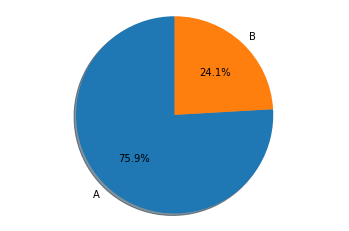

Initial distribution
19536
(array([0, 1]), array([14831,  4705]))
[0.75916257 0.24083743]
(array([-1,  1]), array([    7, 19529]))
Distribution after anomaly detection
19529
[0.75917866 0.24082134]
Distribution after balancing
29652
[0.5 0.5]


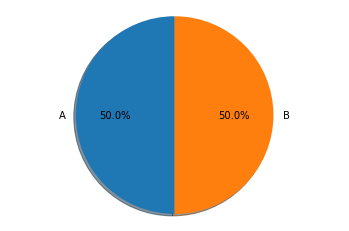

In [14]:
#BALANCING 

#Visualizzazone dello sbilanciamento del dataset
n_classes = len(np.unique(y_tr_processed))
fig, ax = plt.subplots()
sizes = [len(y_tr_processed[y_tr_processed==i]) for i in range(n_classes)]
print(sizes)
class_names = [chr(ord('A')+i) for i in range(n_classes)]
ax.pie(sizes, labels=class_names, autopct='%1.1f%%',shadow=True,startangle=90)
ax.axis("equal")
plt.show()


#ANOMALY DETECTION CON ISOLATION FOREST (metodo di bilanciamento usato = SMOTE)
print("Initial distribution")
print(len(x_tr_pd))
print(np.unique(y_tr_processed, return_counts=True))
print(np.unique(y_tr_processed, return_counts=True)[1]/len(y_tr_processed))

anomaly_detector = IsolationForest()
anomaly_detector.fit(x_tr_processed)
is_inlier = anomaly_detector.predict(x_tr_processed)

print(np.unique(is_inlier, return_counts=True))
x_tr_not_anomalous = x_tr_processed[is_inlier==1,:]
y_tr_not_anomalous = y_tr_processed[is_inlier==1]

print("Distribution after anomaly detection")
print(x_tr_not_anomalous.shape[0])
print(np.unique(y_tr_not_anomalous, return_counts=True)[1]/len(
    y_tr_not_anomalous))

balancer = SMOTE(random_state=42)
x_tr_balanced, y_tr_balanced = balancer.fit_resample(
    x_tr_not_anomalous, y_tr_not_anomalous)

print("Distribution after balancing")
print(x_tr_balanced.shape[0])
print(np.unique(y_tr_balanced, return_counts=True)[1]/len(y_tr_balanced))


#Visualizzazione dataset bilanciato
fig, ax = plt.subplots()
sizes = [len(y_tr_balanced[y_tr_balanced==i]) for i in range(n_classes)]
class_names = [chr(ord("A")+i) for i in range(n_classes)]
ax.pie(sizes, labels = class_names, autopct = "%1.1f%%", shadow = True, 
       startangle = 90)
ax.axis("equal")
plt.show()

In [15]:
#funzione che addestra il modello di classificazione scelto con il trainig set e stampa le varie misure di accuratezza oltre alla confusion matrix
def train_evaluate(model, x_tr, y_tr, x_ts, y_ts):
  model.fit(x_tr, y_tr)
  y_tr_pred = model.predict(x_tr)
  y_ts_pred = model.predict(x_ts)

  print("Confusion matrix on training set")
  print(confusion_matrix(y_tr, y_tr_pred))
  print("Confusion matrix on test set")
  print(confusion_matrix(y_ts, y_ts_pred))
  print("Accuracy on training set: {}".format(accuracy_score(y_tr, y_tr_pred)))
  print("Accuracy on test set: {}".format(accuracy_score(y_ts, y_ts_pred)))
  print("F1 score on training set: {}".format(f1_score(y_tr, y_tr_pred)))
  print("F1 score on test set: {}".format(f1_score(y_ts, y_ts_pred)))

In [16]:
#CROSS VALIDATION GradientBoostingClassifier

#SBILANCIATO
#best configuration {'max_depth': 5, 'n_estimators': 100}
#best score 0.866451758764876
#Accuracy on training set 0.8847768222768223
#Accuracy on test set 0.8738482800982801

#BILANCIATO
#best configuration {'max_depth': 5, 'n_estimators': 100}
#best score 0.8861822993656959
#Accuracy on training set 0.9026709834075273
#Accuracy on test set 0.8438267813267813

est = GradientBoostingClassifier()
parameters =  {'n_estimators':[1,10,100], 'max_depth':[1, 2, 3, 4, 5]}
gs = GridSearchCV(estimator=est, param_grid = parameters)
est.get_params().keys()
#gs.fit(x_tr_processed, y_tr_processed)
gs.fit(x_tr_balanced, y_tr_balanced)


print(gs.cv_results_)
print(gs.best_params_)
print(gs.best_score_)

#print("Accuracy on training set {}".format(accuracy_score(y_tr_processed, gs.predict(x_tr_processed))))
print("Accuracy on training set {}".format( accuracy_score(y_tr_balanced, gs.predict(x_tr_balanced))))
print("Accuracy on test set {}".format(accuracy_score(y_ts_processed, gs.predict(x_ts_processed))))

{'mean_fit_time': array([ 0.05104022,  0.34815035,  3.20480943,  0.07531304,  0.61343131,
        5.93923836,  0.14459848,  1.04633422,  8.52300777,  0.12391138,
        1.09851837, 10.84149599,  0.12549477,  1.33636918, 11.25956755]), 'std_fit_time': array([1.59689006e-03, 7.24326778e-03, 7.62318804e-02, 9.11217087e-04,
       1.92669803e-02, 6.72759913e-02, 6.15919530e-03, 1.83609585e-01,
       1.07802065e-01, 3.82247102e-03, 1.42630116e-02, 1.20846040e+00,
       2.70884270e-03, 2.10137877e-01, 4.91838957e-01]), 'mean_score_time': array([0.00388713, 0.00434313, 0.00858927, 0.00388546, 0.00471358,
       0.01227422, 0.00526109, 0.00589986, 0.01402259, 0.00387821,
       0.00525951, 0.01626868, 0.00389528, 0.00679646, 0.01996279]), 'std_score_time': array([1.41748088e-04, 5.72479897e-05, 2.46642378e-04, 1.37198853e-04,
       1.28459205e-04, 2.42001825e-03, 9.38357617e-05, 1.25012998e-03,
       9.25665002e-04, 4.47647247e-05, 1.05580620e-04, 7.04312815e-04,
       9.49426968e-05, 1.

In [17]:
#CLASSIFICAZIONE
print("Gradient Boosting")
classifier = GradientBoostingClassifier(n_estimators=100, max_depth=5)
print("---RESULT---")
train_evaluate(
    classifier, x_tr_balanced, y_tr_balanced, x_ts_processed, y_ts_processed)

Gradient Boosting
---RESULT---
Confusion matrix on training set
[[13020  1806]
 [ 1080 13746]]
Confusion matrix on test set
[[8529 1359]
 [ 673 2463]]
Accuracy on training set: 0.9026709834075273
Accuracy on test set: 0.8439803439803439
F1 score on training set: 0.9049970373296464
F1 score on test set: 0.7079620580626615
